# Resturant Food Safety Inspection Prediction Using Natual Language Processing

## Summary
1. [Objective](#objective)
2. [Understanding the Data](#data)\
    2.1 [Observations](#observations)\
    2.2 [Feature Engineering](#engineering)
4. [Model Building](#model)
5. [Interpretation of Results](#interpretation)
6. [References](#references)



# 1. Objective
<a id='objective'></a>

The goal of this notebook is to build a multinomial classification model to predict the outcome of the food safety inspection reports based on the inspectors' comments. I will use from statistical analysis and natural language processing to accomplish this. I will also present the results of the classification model and suggest ways that it could be improved through further analysis.

Data provided by the City of Chicago via https://data.cityofchicago.org/ https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5 as of early 2020

In [134]:
import sklearn

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import itertools
import os


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

import nltk as nltk
import nltk.corpus  
from nltk.text import Text

import sys

pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 999
pd.options.mode.chained_assignment = None  # default='warn'


# 2. Understanding the Data
<a id='data'> </a>

In [135]:
#load the data
df = pd.read_csv('../Food_Inspections.csv')
df.head(5)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2369955,HUMBOLDT HAUS DELI & LIQUOR,HUMBOLDT HAUS DELI & LIQUOR,2192995.0,Liquor,Risk 1 (High),2956-2958 W NORTH AVE,CHICAGO,IL,60647.0,04/30/2020,Canvass Re-Inspection,Pass,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, SUPPLIED, & CLEANED - Comments: 5-501.17 OBSERVED NO COVERED WASTE RECEPTACLE INSIDE OF THE WOMEN'S WASHROOM. MUST PROVIDE.",41.910286,-87.701373,"(-87.70137268454522, 41.91028581429125)"
1,2369959,SUPER JALAPENO GRILL INC.,JALAPENO GRILL,2252227.0,Restaurant,Risk 1 (High),2910 W ARMITAGE AVE,CHICAGO,IL,60647.0,04/30/2020,Canvass Re-Inspection,Pass,NaN,41.917572,-87.699859,"(-87.69985903100972, 41.917572160779464)"
2,2369952,CUPBOARD FOOD & LIQUOR,CUPBOARD FOOD & LIQUOR,7110.0,Grocery Store,Risk 3 (Low),3260 W 55TH ST,CHICAGO,IL,60632.0,04/30/2020,Canvass,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: NO PROCEDURE IN PLACE FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS. INSTD TO PROVIDE PROCEDURE AND NECESSARY SUPPLIES EFFECTIVE AGAINST NOROVIRUS. PRIORITY FOUNDATION 7-38-005 | 36. THERMOMETERS PROVIDED & ACCURATE - Comments: MISSING FOOD TEMPERATURE MEASURING DEVICE. INSTD TO PROVIDE AND MAINTAIN SAME. PRIORITY FOUNDATION 7-38-005. | 51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICES - Comments: MISSING TOILET TANK COVER. INSTD TO REPLACE AND MAINTAIN. TOILET HANDLE LOOSE. INSTD TO REPAIR AND MAINTAIN.,41.793589,-87.705946,"(-87.70594578345793, 41.79358917945885)"
3,2369943,Los Jazmines,LOS JAZMINES,2009462.0,Grocery Store,Risk 2 (Medium),1100 W 18th ST,CHICAGO,IL,60608.0,04/30/2020,Canvass Re-Inspection,Pass,NaN,41.858106,-87.653463,"(-87.6534630311116, 41.85810623692298)"
4,2369936,"THALIA HALL CHICAGO, LLC",THALIA HALL,2294344.0,Liquor,Risk 3 (Low),1807 S ALLPORT ST,CHICAGO,IL,60608.0,04/30/2020,Canvass,Out of Business,NaN,41.857676,-87.657496,"(-87.65749590342607, 41.85767620809241)"


In [136]:
df.dtypes

Inspection ID        int64
DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Results             object
Violations          object
Latitude           float64
Longitude          float64
Location            object
dtype: object

In [137]:
df = df.astype({'Inspection ID': 'object', 
                'Zip': 'object'})

In [138]:
df.sample(n=5, random_state=123)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
48,2369355,DUNKIN DONUT,DUNKIN DONUT,28690.0,Restaurant,Risk 2 (Medium),1127 W BRYN MAWR AVE,CHICAGO,IL,60660,04/17/2020,Canvass Re-Inspection,Pass,NaN,41.983529,-87.659155,"(-87.65915456081615, 41.98352906115736)"
131413,1424359,WENDY'S #000981,WENDY'S,6780.0,Restaurant,Risk 1 (High),5456 N HARLEM AVE,CHICAGO,IL,60656,07/02/2014,Canvass,Pass w/ Conditions,"2. FACILITIES TO MAINTAIN PROPER TEMPERATURE - Comments: SALAD REACH IN COOLER NOT MAINTAINED, AMBIENT AIR TEMEPRATURE AT 68.0 F, FOUND SALAD DRESSING AND SALAD WITH CHOPPED LEAFY GREENS INSIDE SAID COOLER. INSTRUCTED MANAGER TO REPAIR COOLER, AMBIENT AIR TEMPERATURE MUST BE 40 F OR BELOW. CRITICAL VIOLATION 7-38-005(A). | 3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATURE REQUIREMENT DURING STORAGE, PREPARATION DISPLAY AND SERVICE - Comments: FOUND THE FOLLOWING POTENTIALLY HAZARDOUS FOODS HELD AT IMPROPER TEMPERATURES BETWEEN 45.5 F AND 54.8 F- SALAD DRESSING, OPEN MAYONNAISE AND CHOPPED SALAD WITH LEAFY GREENS. INSTRUCTED MANAGER ALL POTENTIALLY HAZARDOUS FOODS MUST BE HELD AT 40 F OR BELOW IF HELD COLD. CRITICAL VIOLATION 7-38-005(A). ALL OUT OF TEMPERATURE POTENTIALLY HAZARDOUS FOODS VOLUNTARILLY DISCARDED AT THIS TIME. | 32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED - Comments: OBSERVED ICE BUILD UP ON REAR OF CONDENSERS INSIDE WALK IN...",41.979892,-87.807127,"(-87.80712701444871, 41.979892458487015)"
113274,1532472,POLISH FOOD,POLISH FOOD,1694804.0,Restaurant,Risk 1 (High),3104 N CENTRAL AVE,CHICAGO,IL,60634,03/31/2015,Canvass,Pass,"40. REFRIGERATION AND METAL STEM THERMOMETERS PROVIDED AND CONSPICUOUS - Comments: INSTRUCTED TO PROVIDE THERMOMETER VISIBLE AND ACCURATE INSIDE COOLERS. | 41. PREMISES MAINTAINED FREE OF LITTER, UNNECESSARY ARTICLES, CLEANING EQUIPMENT PROPERLY STORED - Comments: INSTRUCTED TO CLEAN AND REMOVE UNNECESSARY ARTICLES AND CLUTTER STORED ON TOP OF WALK-IN COOLER/WALK-IN FREEZER AND IN REAR OUTSIDE AREA TO PREVENT PEST HARBORAGE. | 45. FOOD HANDLER REQUIREMENTS MET - Comments: FOUND NO EMPLOYEE FOOD HANDLER TRAINING CERTIFICATES ON PREMISE. INSTRUCTED TO PROVIDE.",41.936954,-87.766589,"(-87.76658858129136, 41.93695400157263)"
16787,68106,THE FOUR SEASONS HOTEL CHICAGO,THE FOUR SEASONS HOTEL CHICAGO,1823680.0,Restaurant,Risk 1 (High),120 E DELAWARE PL,CHICAGO,IL,60611,02/02/2010,Canvass,Pass,"38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED - Comments: The flow of air discharged from kitchen fans shall always be through a duct to a point above the roofline. Ventilation: All plumbing fixtures, such as toilets, sinks, washbasins, etc., must be adequately trapped, vented, and re-vented and properly connected to the sewer in accordance with the plumbing chapter of the Municipal Code of Chicago and the Rules and Regulations of the Board of Health. vENTILATION UNIT ABOVE COOKING EQUIPMENT IN NEED OF CLEANING TO REMOVE DUST/GREASE BUILD-UP. ANSEL SYSTEM IN NEED OF CLEANING AS WELL.",41.899304,-87.625236,"(-87.62523649147974, 41.89930409644498)"
98148,1771104,TREAT AMERICA FOOD SERVICES,TREAT AMERICA FOOD SERVICES,2299237.0,Restaurant,Risk 1 (High),225 W RANDOLPH ST,CHICAGO,IL,60606,05/19/2016,Canvass,Out of Business,NaN,41.884356,-87.634637,"(-87.6346365498915, 41.88435557962178)"


In [139]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205234 entries, 0 to 205233
Data columns (total 17 columns):
Inspection ID      205234 non-null object
DBA Name           205234 non-null object
AKA Name           202763 non-null object
License #          205217 non-null float64
Facility Type      200408 non-null object
Risk               205164 non-null object
Address            205234 non-null object
City               205084 non-null object
State              205190 non-null object
Zip                205181 non-null object
Inspection Date    205234 non-null object
Inspection Type    205233 non-null object
Results            205234 non-null object
Violations         150738 non-null object
Latitude           204546 non-null float64
Longitude          204546 non-null float64
Location           204546 non-null object
dtypes: float64(3), object(14)
memory usage: 26.6+ MB
None
          License #       Latitude      Longitude
count  2.052170e+05  204546.000000  204546.000000
mean   1.6137

In [140]:
pd.DataFrame({'count':df.Results.value_counts(),
              'percent':df.Results.value_counts()/len(df)})

,count,percent
Pass,108721,0.529742
Fail,39640,0.193145
Pass w/ Conditions,30183,0.147066
Out of Business,17763,0.086550
No Entry,6803,0.033148
Not Ready,2052,0.009998
Business Not Located,72,0.000351


In [141]:
df.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Results', 'Violations', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

### 2.1 Observations
<a id='observations'></a>
* There are a lot of extra unneccesary columns
* We care about 'results', and 'violations'
* \>50K N/A's in violations column
* This is a multinomial classification problem. We'll narrow the classes to pass, fail, and pass w/ conditions due to data insufficency and other limitations.


In [142]:
#Drop Unneccesary Columns
select_cols = ['Results', 'Violations']
df = df[select_cols]

#Drop classes with insufficient data
df = df[(df.Results=='Pass')|(df.Results=='Fail')|(df.Results=='Pass w/ Conditions')]

#drop N/As
df = df.dropna(subset =['Violations'], axis=0)


In [143]:
df.head(2)

,Results,Violations
0,Pass,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, SUPPLIED, & CLEANED - Comments: 5-501.17 OBSERVED NO COVERED WASTE RECEPTACLE INSIDE OF THE WOMEN'S WASHROOM. MUST PROVIDE."
2,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: NO PROCEDURE IN PLACE FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS. INSTD TO PROVIDE PROCEDURE AND NECESSARY SUPPLIES EFFECTIVE AGAINST NOROVIRUS. PRIORITY FOUNDATION 7-38-005 | 36. THERMOMETERS PROVIDED & ACCURATE - Comments: MISSING FOOD TEMPERATURE MEASURING DEVICE. INSTD TO PROVIDE AND MAINTAIN SAME. PRIORITY FOUNDATION 7-38-005. | 51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICES - Comments: MISSING TOILET TANK COVER. INSTD TO REPLACE AND MAINTAIN. TOILET HANDLE LOOSE. INSTD TO REPAIR AND MAINTAIN.


In [144]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150186 entries, 0 to 205233
Data columns (total 2 columns):
Results       150186 non-null object
Violations    150186 non-null object
dtypes: object(2)
memory usage: 3.4+ MB
None
       Results  \
count   150186   
unique       3   
top       Pass   
freq     84015   

                                                                                                                                Violations  
count                                                                                                                               150186  
unique                                                                                                                              149347  
top     45. FOOD HANDLER REQUIREMENTS MET - Comments: ALL FOOD HANDLING EMPLOYEES MUST SHOW PROOF OF FOOD HANDLER TRAINING.  MUST PROVIDE.  
freq                                                                                                                

## 2. Feature Engineering
<a id='engineering'></a>
* Extract only comments from violations, drop rest of text
* map Results_Flag

In [145]:
#Check sample Violation entry
df.iloc[131413]['Violations']

'2. FACILITIES TO MAINTAIN PROPER TEMPERATURE - Comments: All food establishments that display, prepare, or store potentially hazardous food shall have adequate refrigerated food storage facilities.    MUST HAVE COOLER AT 40F OR BELOW, FREEZER UNDER 0F. | 18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS - Comments: MUST PROVIDE PEST CONTROL LOG BOOK. | 33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS - Comments: All utensils shall be thoroughly cleaned and sanitized after each usage.    MUST CLEAN-SANITIZE; EQUIPMENT, SINKS, COUNTERS, ETC.. | 34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED - Comments: The floors shall be constructed per code, be smooth and easily cleaned, and be kept clean and in good repair.    MUST CLEAN FLOORS THRU-OUT PREMISES, INCLUDINT BASEMENT. | 35. WALLS, CEILINGS, ATTACHED EQUIPM

In [146]:
#regex expression to extract the text following "Comments:"
df.Violations = df.Violations.str.findall(r"(?:\sComments:\s.*?)?(?:[|]|$)")

In [147]:
#Now check sample violation
df.iloc[131413]['Violations']

[' Comments: All food establishments that display, prepare, or store potentially hazardous food shall have adequate refrigerated food storage facilities.    MUST HAVE COOLER AT 40F OR BELOW, FREEZER UNDER 0F. |',
 ' Comments: MUST PROVIDE PEST CONTROL LOG BOOK. |',
 ' Comments: All utensils shall be thoroughly cleaned and sanitized after each usage.    MUST CLEAN-SANITIZE; EQUIPMENT, SINKS, COUNTERS, ETC.. |',
 ' Comments: The floors shall be constructed per code, be smooth and easily cleaned, and be kept clean and in good repair.    MUST CLEAN FLOORS THRU-OUT PREMISES, INCLUDINT BASEMENT. |',
 ' Comments: The walls and ceilings shall be in good repair and easily cleaned.    MUST SEAL RAW WOOD DOOR FRAME FOR MOP CLOSET. |',
 ' Comments: Ventilation: All plumbing fixtures, such as toilets, sinks, washbasins, etc., must be adequately trapped, vented, and re-vented and properly connected to the sewer in accordance with the plumbing chapter of the Municipal Code of Chicago and the Rules an

In [148]:
#Lemmatize Violations
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df.Violations = df.Violations.str.join(' ')

#remove "Comments"
df['Violations'] = df['Violations'].str.replace('Comments*\s','')
df['Violations'] = df['Violations'].str.replace('Comments','')

#Remove Punctuation
df['Violations'] = df['Violations'].str.replace('[^\w\s]','')

#Remove non-alphanumeric
df['Violations'] = df['Violations'].str.replace('[^\D\s]','')


In [149]:
#Now check sample violation
df.iloc[131413]['Violations']

'  All food establishments that display prepare or store potentially hazardous food shall have adequate refrigerated food storage facilities    MUST HAVE COOLER AT F OR BELOW FREEZER UNDER F    MUST PROVIDE PEST CONTROL LOG BOOK    All utensils shall be thoroughly cleaned and sanitized after each usage    MUST CLEANSANITIZE EQUIPMENT SINKS COUNTERS ETC    The floors shall be constructed per code be smooth and easily cleaned and be kept clean and in good repair    MUST CLEAN FLOORS THRUOUT PREMISES INCLUDINT BASEMENT    The walls and ceilings shall be in good repair and easily cleaned    MUST SEAL RAW WOOD DOOR FRAME FOR MOP CLOSET    Ventilation All plumbing fixtures such as toilets sinks washbasins etc must be adequately trapped vented and revented and properly connected to the sewer in accordance with the plumbing chapter of the Municipal Code of Chicago and the Rules and Regulations of the Board of Health    MUST REPLACE FRONT PREP AREA PART SINK FAUCET    All food establishments th

In [150]:
df['Results'].value_counts()

Pass                  84015
Fail                  36500
Pass w/ Conditions    29671
Name: Results, dtype: int64

In [151]:
# convert label to a binary numerical variable
df['Results_Flag'] = df.Results.map({'Pass':0,
                                     'Fail':1,
                                     'Pass w/ Conditions':2,
                                     'No Entry':3,
                                     'Not Ready':4,
                                     'Out of Business':5 })

## 3. Set X & y Variables, Train/Test Split

In [16]:
X = df.Violations
y = df.Results_Flag
print(X.shape)
print(y.shape)

(150186,)
(150186,)


In [17]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    stratify=y, 
                                                    random_state=123)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(120148,)
(30038,)
(120148,)
(30038,)


## 4. Vectorize The Text

In [18]:
# instantiate the vectorizer
vect = CountVectorizer()

In [19]:
# equivalently: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

In [20]:
# examine the document-term matrix
X_train_dtm

<120148x89708 sparse matrix of type '<class 'numpy.int64'>'
	with 8115815 stored elements in Compressed Sparse Row format>

In [21]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<30038x89708 sparse matrix of type '<class 'numpy.int64'>'
	with 2009325 stored elements in Compressed Sparse Row format>

In [22]:
countvectorizer_matrix = vect.fit_transform(X_train)
countvectorizer_matrix_df = pd.DataFrame(countvectorizer_matrix.toarray(), columns=vect.get_feature_names())
countvectorizer_matrix_df

,___lbs,__through,_a,aa,aab,aade,aafound,aal,aall,aamust,...,zuchinicabbagecooked,zuchinisasparagus,zumba,zumex,zurich,ï½,ï½c,ï½f,ï½time,ï½ï½
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120143,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120144,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
X_train

33499                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       INSTRUCTED TO PROPERLY LABEL FOOD STORAGE CONTAINERSBINS IDENTIFIED WITH COMMON NAME    INSTRUCTED TO TRANSFER FOOD PRODUCTS FROM AN OPEN ORIGINAL CAN CONTAINER INTO FOOD GRADE CONTAINER FOR PROPER FOOD STORAGE      INSTRUCTED TO REPAIR LOOSE HANDSINK IN BAKERY PREP AREA    INSTRUCTED TO RE GROUT FLOOR TILES WITH DEEP SEAMS AND CRACKED AROUND MEAT PREP AREA     FOOD AND NON FOOD ITEMS MUST BE STORED  OFF THE FLOOR FOR EASY ACCESS ON CLEANING MUST PROVIDE PROPER RAISED SHELVES AND NO MILK

## 5. Build Baseline Models
* Naive Bayes Model
* Logistic Regression
* Support Vector Machine

### a) Naive Bayes Model

In [24]:
# instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

In [25]:
# train and time the model using X_train_dtm
%time nb.fit(X_train_dtm, y_train)

CPU times: user 85.2 ms, sys: 172 ms, total: 257 ms
Wall time: 389 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [26]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [27]:
# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

0.8257207537119648


In [28]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     16804
           1       0.73      0.72      0.73      7300
           2       0.65      0.77      0.71      5934

    accuracy                           0.83     30038
   macro avg       0.78      0.79      0.78     30038
weighted avg       0.84      0.83      0.83     30038



In [29]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[14941   820  1043]
 [  626  5277  1397]
 [  239  1110  4585]]


### b) Logistic Regression

In [30]:
# instantiate a logistic regression model
logreg = LogisticRegression(max_iter=1000)

In [31]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 10min 46s, sys: 2min 52s, total: 13min 39s
Wall time: 2min 52s


/Users/stephenstark/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)
y_pred_class_train = logreg.predict(X_train_dtm)

In [33]:
# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

0.9241627272121978


In [34]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))
print(classification_report(y_train, y_pred_class_train))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     16804
           1       0.88      0.84      0.86      7300
           2       0.86      0.85      0.85      5934

    accuracy                           0.92     30038
   macro avg       0.90      0.89      0.90     30038
weighted avg       0.92      0.92      0.92     30038

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     67211
           1       0.96      0.93      0.95     29200
           2       0.95      0.94      0.95     23737

    accuracy                           0.97    120148
   macro avg       0.96      0.96      0.96    120148
weighted avg       0.97      0.97      0.97    120148



In [35]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[16613   118    73]
 [  403  6119   778]
 [  188   718  5028]]


### c) Support Vector Machine

In [36]:
# instantiate a SVM model
svm = SGDClassifier(max_iter=100, tol=None)

In [37]:
# train the model using X_train_dtm
%time svm.fit(X_train_dtm, y_train)

CPU times: user 9.9 s, sys: 177 ms, total: 10.1 s
Wall time: 9.3 s


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=100, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [38]:
# make class predictions for X_test_dtm
y_pred_class = svm.predict(X_test_dtm)

In [39]:
# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

0.916938544510287


In [40]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     16804
           1       0.88      0.82      0.85      7300
           2       0.86      0.85      0.85      5934

    accuracy                           0.92     30038
   macro avg       0.90      0.88      0.89     30038
weighted avg       0.92      0.92      0.92     30038



In [41]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[16557   150    97]
 [  590  5966   744]
 [  239   675  5020]]


### 6. Improve Model Performance (for best performing model)
* Remove stopwords
* Include n-grams
* Limit min & max document frequencies



In [42]:
#default parameters for countvectorizer model
CountVectorizer()

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [43]:
# remove English stop words
vect_optimized = CountVectorizer(stop_words='english',
                                 lowercase=True,
                                 ngram_range=(1,4), 
                                 min_df=0.1, 
                                 max_df=0.2)



In [44]:
countvectorizer_matrix = vect_optimized.fit_transform(X_train)
countvectorizer_matrix_df = pd.DataFrame(countvectorizer_matrix.toarray(), columns=vect_optimized.get_feature_names())
countvectorizer_matrix_df

,area instructed,basement,broken,buildup,ceiling tiles,ceilings,chicago,citation,citation issued,clean floors,...,toilet,use,used,utensils,utensils shall,ventilation,walk,walkin,washing,washroom
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,3,2,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120143,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
120144,0,0,0,0,0,0,0,0,0,0,...,1,2,0,2,0,0,0,0,0,0
120145,0,0,0,0,2,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
120146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# equivalently: combine fit and transform into a single step
X_train_dtm = vect_optimized.fit_transform(X_train)
X_test_dtm = vect_optimized.transform(X_test)


In [46]:
#Logistitc Regression
model = LogisticRegression(max_iter=500)
%time model.fit(X_train_dtm, y_train)

# make class predictions for X_test_dtm
y_pred_class = model.predict(X_test_dtm)

# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

CPU times: user 13 s, sys: 75.2 ms, total: 13.1 s
Wall time: 13.3 s
0.8385711432185898


In [47]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     16804
           1       0.77      0.62      0.68      7300
           2       0.76      0.72      0.74      5934

    accuracy                           0.84     30038
   macro avg       0.80      0.77      0.78     30038
weighted avg       0.83      0.84      0.83     30038



In [48]:
#Check for over fitting
y_pred_class_train = model.predict(X_train_dtm)
print(classification_report(y_train, y_pred_class_train))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     67211
           1       0.77      0.62      0.69     29200
           2       0.76      0.72      0.74     23737

    accuracy                           0.84    120148
   macro avg       0.81      0.77      0.79    120148
weighted avg       0.83      0.84      0.83    120148



Text(69.0, 0.5, 'Actual')

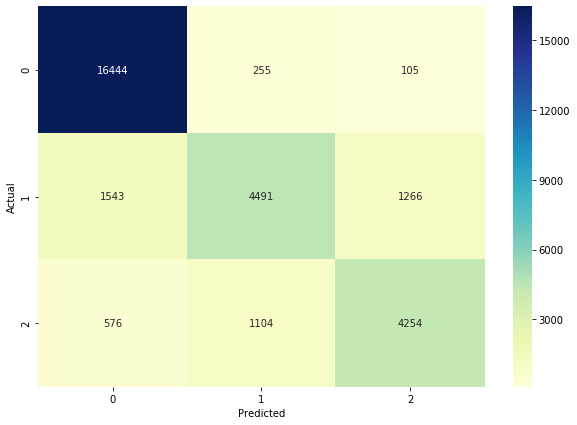

In [49]:
cnf_matrix_test = confusion_matrix (y_test, y_pred_class)

import seaborn as sns

plt.figure(figsize = (10,7))
sns.heatmap(cnf_matrix_test, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

### 7. Troubleshoot

In [50]:
X_test_df = pd.DataFrame(X_test)
X_test_df.reset_index(inplace=True, drop=True)

y_test_df = pd.DataFrame(y_test)
y_test_df.reset_index(inplace=True, drop=True)

In [51]:
y_pred_prob = model.predict_proba(X_test_dtm)
y_pred_class = model.predict(X_test_dtm)

In [52]:
y_pred_prob_df = pd.DataFrame(y_pred_prob)
y_pred_prob_df.columns = ['0-prob', '1-prob', '2-prob']

y_pred_class_df = pd.DataFrame(y_pred_class)
y_pred_class_df.columns = ['predicted']

In [53]:
results_df = X_test_df.join(y_test_df).join(y_pred_class_df).join(y_pred_prob_df)

In [54]:
results_review_df = results_df[(results_df['0-prob'] < 0.6) & (results_df['1-prob'] < 0.6) & (results_df['2-prob'] < 0.6)]
results_review_df.shape

(3324, 6)

In [55]:
pd.set_option('display.max_colwidth', 200)

In [56]:
results_review_df.head(10)

,Violations,Results_Flag,predicted,0-prob,1-prob,2-prob
12,NO VALID CITY OF CHICAGO FOOD SERVICE MANAGER CERTIFICATE POSTED AND NO VALID PROOF OF ENROLLMENT AVAILABLE AT THIS TIME SERIOUS CITATION ISSUED MUST SEAL SMALL OPENING ALONG THE BOTTOM OF ...,1,1,3.159360e-02,0.535263,0.433144
22,THE FOLLOWING PREVIOUS MINOR VIOLATIONS NOTED ON REPORT STILL NOT CORRECTED CLEAN THE FOLLOWING INTERIOR CABINETS OF DEEP FRYERS OVEN EXPOSED WASHBOWL IN EMPLOYEE WASHROOM INTERIORS EXTERIOR...,1,1,1.269582e-01,0.503785,0.369257
26,OBSERVED THE FOLLOWING FOODS STORED AT IMPROPER TEMPERATURE IN PREP COOLER SEAFOOD SALAD F CRABMEAT F COOKED FISH F CREAM CHEESE F INSTRUCTED MANAGER TO DISCARD APPROXIMATELY LBS AND OF FOOD AL...,2,1,4.958360e-14,0.576090,0.423910
46,NOTED EMPLOYEES PREPPING SANDWICHES MOVING FROM PREP TABLE TO REFRIGERATION UNIT AT THE REAR AND TO THE CASH REGISTRY WHILE CHANGING GLOVES DID NOT OBSERVE EMPLOYEES WASHING HANDS IN BETWEEN INS...,2,1,2.583357e-04,0.502556,0.497185
57,OBSERVED POOR HYGIENIC PRACTICES BY FOOD HANDLERSOBSERVED MALE FOOD HANDLER WALKING AROUND IN LOBBY AND THEN CAME INTO PREP AREA AND STARTED COOKING AND A FEMALE FOOD HANDLER WAS TOUCHING AND HA...,2,0,3.864483e-01,0.250663,0.362889
86,LEOBARDO CARDENAS HAS NO CURRENT SANITATION CERTIFICATE POSTED OR AVAILABLE AT THIS TIME OF INSPECTION ONLY HAS A REGISTRATION FORM ONLY NO RECEIPT CITATION ISSUED LABEL BULK FOOD CONTAINER...,2,2,3.309864e-02,0.460274,0.506627
90,FOUND A NONWORKING GLASSWARE MACHINE AT THE BAR AREA NOT IN USE AND NOT PROPERLY SANITIZING AT PPM CHLORINEMACHINE WAS TAGGED AT THIS TIME DO NOT USE MACHINE UNTIL REPAIRED AND CDPH INSPECTS UNI...,2,2,1.526504e-01,0.347723,0.499627
91,Found potentially hazardous foods sliced tomatoes steak chicken etc without proper labels Must label all prepped potentially hazardous foods with name and date Must maintain same Found bulk food...,0,2,4.016666e-01,0.104585,0.493748
114,OBSERVED MULTIPLE SPRAY BOTTLES OF CHEMICALS THROUGHOUT FACILITY WITHOUT PROPER LABELS IN COOK LINE NEAR MOP SINK AND AT ND FLOOR BAR MUST PROVIDE LABEL WITH COMMON NAME OF CHEMICAL ON ALL CHEMI...,2,2,7.227539e-02,0.432295,0.495429
115,ALL STORAGE ROOMS MUST BE PROPERLY ORGANIZED WITH ALL ITEMS ELEVATED INCHES OFF THE FLOORS ALL AREAS MUST BE ACCESSIBLE FOR CLEANING SERVICING BY PEST CONTROL AND INSPECTION ICE SCOOPS MUST ...,0,1,2.103451e-01,0.588122,0.201533


# Summary
I decided to perform a multi-class classification analysis.  I narrowed my dataset to pass, fail, or pass w/ conditions due to the sufficiency of data. It appears the logistic regression had the best performance of the three models I demonstrated above. The original logisitc regression actually performed better than the one I attempted to optimize. It had a test accuracy of 92%.  The model showed slight signs of overfitting as train accuracy was 96%. Precision and recall for test were 92% for each. Precision was 96% for class 0 (pass), 87% for class 1 (fail) and 86% for class 2 (pass w/ conditions). Furthermore we know f-1 scores are the weighted averaged of precision and recall. F1 scores of 98%, 86%, and 85%, for the same classes listed previously. The model clearly is able to accuractely identify pass recommendations but struggles a little more with fail and pass with conditions, which makes sense intuitively. the F1 scores show slightly more signs of overfitting so I would attempt to adjust that in my parameter tuning. This is out of scope for this analysis, but perhaps I would do some sort of grid search or random search to approximate better parameter values.
* **Pre-processing** For text pre-processing, I decided that we needed to remove stopwords for this analysis. They are noise and do not contribute to the signal of the prediction. I also removed all the digits as again I believe they were more of a distraction. Also, within CountVectorizer, I included parameters to lowercase all words an
* **Train/Test Split** I noticed a considerable class imbalance in the dataset between the three values. I made sure to stratify my sampling in train test split to ensure the train samples and test samples resembled the population of the dataset. Another thing I considered doing but did not as it was out of scope for this analysis was training my model on an equal split data using an under-sampling or oversampling approach. This would give the model a fair chance to fully train each class equally as opposed to seeing more data of the dominate class.


<a id='end'> </a>